# **Machine Learning Pipeline**

## **Imports and data loading**

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
from matplotlib import pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# # This module lets us save our models once we fit them.
import pickle

In [2]:
# Import dataset
df0 = pd.read_csv('../data/waze_dataset.csv')

In [3]:
# Inspect the first five rows
df0.head(5)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [4]:
# Copy the df0 dataframe
df = df0.copy()

In [5]:
# Get class balance of 'label' col
df['label'].value_counts(normalize = True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

> With 18% churners, the dataset is moderately imbalanced, so accuracy can be misleading since it may overlook minority class predictions. Given that false positives have minimal consequences, the focus should be on maximizing recall, ensuring the model correctly identifies as many churned users as possible.

## **Helper Functions**

In [6]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [7]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

## **Feature engineering**

### **Data Preprocessing**

In [8]:
# Drop `ID` column
df.drop('ID', axis = 1, inplace = True)

In [9]:
# Drop rows with missing values
df.dropna(inplace = True)

> Tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Variable Encoding**

In [10]:
# Create new `device2` variable
df['device2'] = pd.get_dummies(df['device'], drop_first = True).astype(int)
df.head(3)

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,device2
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,0
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,0


In [11]:
# Create binary `label2` column
df['label2'] = np.where(df['label'] == 'retained', 0, 1)
df.head(10)

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,device2,label2
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,0,0
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,1,0
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,0,0
5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone,1,0
6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone,1,0
7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone,1,0
8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android,0,0
9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone,1,1


### **Feature Creation**

#### **`km_per_driving_day`**
_Mean number of kilometers driven on each driving day in the last month for each user_

In [12]:
# Convert infinite values to zero
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0

# Confirm that it worked
df['km_per_driving_day'].describe()

count    14299.000000
mean       581.942399
std       1038.254509
min          0.000000
25%        136.168003
50%        273.301012
75%        558.018761
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**
_Percentage of each user's total sessions that were logged in their last month of use_

In [13]:
# Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14299.000000
mean         0.449837
std          0.286863
min          0.000000
25%          0.196890
50%          0.424310
75%          0.687251
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**
_Binary indicator of users classified as professional drivers, defined by having 60 or more drives and driving on 15 or more days in their last month of use_

In [14]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

#### **`total_sessions_per_day`**
_Mean number of sessions per day since onboarding_

In [15]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14299.000000
mean         0.338207
std          1.319814
min          0.000298
25%          0.050818
50%          0.100457
75%          0.215210
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**
_Mean kilometers per hour driven in the last month_

In [16]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)

# Get descriptive stats
df['km_per_hour'].describe()

count    14299.000000
mean       190.730963
std        339.926138
min         72.013095
25%         90.649402
50%        122.105845
75%        193.238449
max      23642.920871
Name: km_per_hour, dtype: float64

#### **`km_per_drive`**
_Mean number of kilometers per drive made in the last month for each user_

In [17]:
# Convert infinite values to zero
df['km_per_drive'] = df['driven_km_drives'] / df['driving_days']
df.loc[df['km_per_drive'] == np.inf, 'km_per_drive'] = 0

# Confirm that it worked
df['km_per_drive'].describe()

count    14299.000000
mean       581.942399
std       1038.254509
min          0.000000
25%        136.168003
50%        273.301012
75%        558.018761
max      15420.234110
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**
_Percentage of total sessions that were used to navigate to one of the users' favorite places_

In [18]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

count    14299.000000
mean         1.676347
std          9.021250
min          0.000000
25%          0.206064
50%          0.653572
75%          1.643183
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

## **Modeling Approach Overview**

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg" width="600">
</div>

1) Split the data into train/validation/test sets (60/20/20)

2) Fit models and tune hyperparameters on the training set

3) Perform final model selection on the validation set

4) Assess the champion model's performance on the test set

## **Train-Validation-Test Split**

In [19]:
# Isolate X variables
X = df.drop(['label', 'device', 'label2'], axis = 1)

# Isolate y variable
y = df['label2']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.25, random_state = 42)

# Verify number of samples in partitioned data
total_obs = 14299
print(X_train.shape[0] / total_obs)
print(X_val.shape[0] / total_obs)
print(X_test.shape[0] / total_obs)

0.5999720260158053
0.20001398699209735
0.20001398699209735


## **Hyperparameter Tuning on Training Set**

### **Random forest**

In [20]:
%%time

# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state = 42)

# Create a dictionary of hyperparameters to tune
cv_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 50],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'max_samples': [0.5, 0.9]}

# Define a list of scoring metrics to capture
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring = scoring, cv = 5, refit = 'recall')

# Fit the model to the training data
rf_cv.fit(X_train, y_train)

CPU times: total: 5min 30s
Wall time: 5min 59s


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 50], 'max_features': ['sqrt', 'log2'], 'max_samples': [0.5, 0.9], 'min_samples_leaf': [1, 5], ...}"
,scoring,"{'accuracy': 'accuracy', 'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}"
,n_jobs,None
,refit,'recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


In [21]:
# Examine best average score across all validation folds
float(rf_cv.best_score_)

0.11891932700603969

In [22]:
# Examine best hyperparameter combinations
rf_cv.best_params_

{'max_depth': 50,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [23]:
# Save results for comparison
rf_cv_results = make_results('RF cv', rf_cv, 'recall')
rf_cv_results

,model,precision,recall,F1,accuracy
0,RF cv,0.479074,0.118919,0.190241,0.820492


* Strengths
  * The model achieves a high overall accuracy (~82%), which aligns closely with the majority class proportion (82.2% retained users), indicating it effectively identifies the majority class (non-churners).
  * Precision (~0.48) shows that when the model predicts a churned user (class 1), it is correct nearly half the time, which is a positive sign given the imbalance.
* Weaknesses
  * The high accuracy is misleading due to class imbalance, as the model mostly predicts the majority class and misses many churned users.
  * Low recall (~0.12) means most actual churners are not identified, limiting the model’s usefulness for churn prediction.
  * The F1 score (~0.19) reflects poor balance between precision and recall, indicating overall weak performance on the minority class.

### **XGBoost**

In [24]:
%%time
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 42)

# Create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [4, 6],
    'min_child_weight': [3, 5],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 150],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]}

# Define a list of scoring metrics to capture
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb,
                      cv_params,
                      scoring = scoring,
                      cv = 5,
                      refit = 'f1')

# Fit the model to the training data
xgb_cv = xgb_cv.fit(X_train, y_train)

CPU times: total: 24min 29s
Wall time: 2min 56s


In [25]:
# Examine best average score across all validation folds
float(xgb_cv.best_score_)

0.27585459617684427

In [26]:
# Examine best hyperparameter combinations
xgb_cv.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 100,
 'subsample': 0.6}

In [27]:
# Save results for comparison
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([rf_cv_results, xgb_cv_results], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.479074,0.118919,0.190241,0.820492
0,XGB cv,0.395443,0.212224,0.275855,0.802658


* Strengths
  * The model achieves an overall accuracy of ~81%, reflecting good identification of the majority class (retained users, 82.2%).
  * Precision (~0.42) indicates that when the model predicts churn, it is correct about 42% of the time, which is moderately useful given the imbalance.
  * Recall (~0.20) is higher than the RF model, meaning this model detects more actual churners.
* Weaknesses
  * Despite better recall than RF, the recall (~0.20) remains relatively low, missing about 80% of churned users, limiting practical effectiveness.
  * The F1 score (~0.27) shows the model still struggles to balance precision and recall effectively.
  * Similar to the RF model, the overall accuracy is somewhat misleading due to class imbalance, as the model tends to favor the majority class.

## **Model Selection Using Validation Set**

### **Random forest**

In [28]:
# Use random forest model to predict on validation data
rf_val = rf_cv.predict(X_val)

# Get validation scores for RF model
rf_pred_results = get_test_scores('RF val', rf_val, y_val)

# Append to the results table
results = pd.concat([results, rf_pred_results], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.479074,0.118919,0.190241,0.820492
0,XGB cv,0.395443,0.212224,0.275855,0.802658
0,RF val,0.418605,0.106509,0.169811,0.815385


The scores dropped only slightly from cross-validation to validation across all metrics, indicating that the model generalizes well and shows no strong signs of overfitting.

### **XGBoost**

In [29]:
# Use XGBoost model to predict on validation data
xgb_val = xgb_cv.predict(X_val)

# Get validation scores for XGBoost model
xgb_pred_results = get_test_scores('XGB val', xgb_val, y_val)

# Append to the results table
results = pd.concat([results, xgb_pred_results], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.479074,0.118919,0.190241,0.820492
0,XGB cv,0.395443,0.212224,0.275855,0.802658
0,RF val,0.418605,0.106509,0.169811,0.815385
0,XGB val,0.386029,0.207101,0.269576,0.801049


The scores dropped only slightly from cross-validation to validation across all metrics, indicating that the model generalizes well and shows no strong signs of overfitting.

## **Final Evaluation on Test Set**

In [30]:
# Use XGBoost model to predict on test data
xgb_test = xgb_cv.predict(X_test)

# Get test scores for XGBoost model
xgb_test_results = get_test_scores('XGB test', xgb_test, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_results], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.479074,0.118919,0.190241,0.820492
0,XGB cv,0.395443,0.212224,0.275855,0.802658
0,RF val,0.418605,0.106509,0.169811,0.815385
0,XGB val,0.386029,0.207101,0.269576,0.801049
0,XGB test,0.346939,0.201183,0.254682,0.791259


* Precision dropped slightly from 38.6% (validation) to 34.7% (test), indicating a small decrease in correctness when predicting churners.
* Recall remained nearly the same: 20.7% (validation) vs. 20.1% (test), showing consistent but low sensitivity to actual churners.
* F1 score decreased slightly from 27.0% to 25.5%, reflecting a modest drop in the balance between precision and recall.
* Accuracy declined marginally from 80.1% (validation) to 79.1% (test), maintaining overall correctness dominated by the majority class.

Overall, the model generalizes well with minimal performance drop, but recall remains low, limiting its usefulness for detecting churn.

### **Confusion matrix**

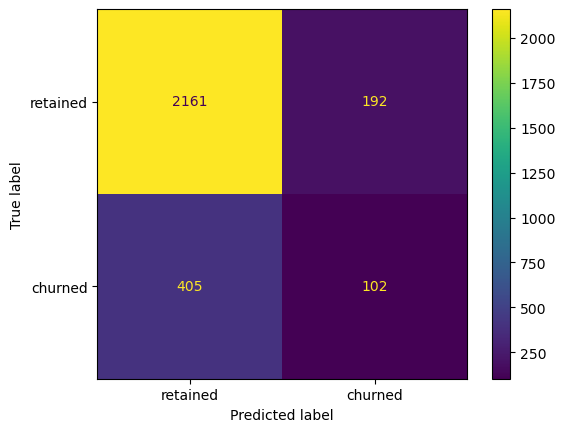

In [31]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test, labels = xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['retained', 'churned'])
disp.plot();

The model produced over twice as many false negatives (405) as false positives (192), correctly identifying only 20.1% of actual churned users.

### **Feature importance**

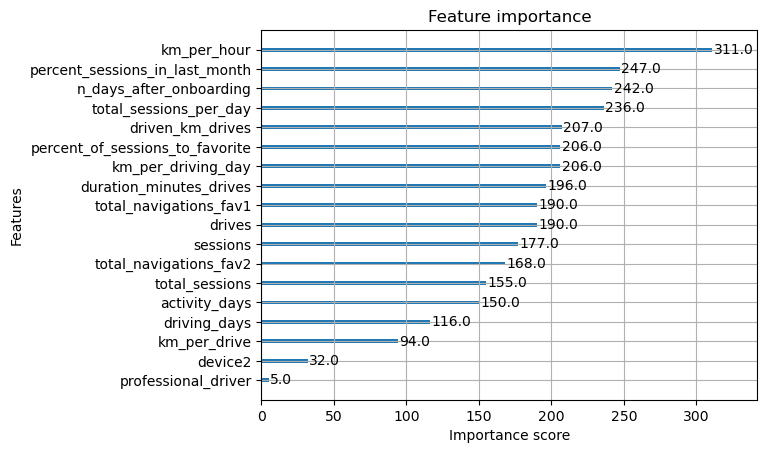

In [32]:
plot_importance(xgb_cv.best_estimator_);

Among the top 10 most important features, five were derived through feature engineering, highlighting its significant contribution to model performance. This demonstrates that thoughtfully engineered features can capture patterns or relationships not directly evident in the raw data, often improving a model’s ability to distinguish between classes. In this case, feature engineering played a key role in enhancing predictive power, reinforcing its value as a critical step in the machine learning pipeline.

## **Data Insights**

* I would not recommend deploying this model for churn prediction, as its recall score (~0.20) is too low for practical use. This means the model correctly identifies only 1 out of every 5 customers who actually churned. Further hyperparameter tuning is necessary to improve its performance before considering implementation.
* Although splitting the data into training, validation, and test sets reduces the amount of data available for initial training, the tradeoff is worthwhile. The validation set enables effective hyperparameter tuning without exposing the test set, which remains untouched for an unbiased final evaluation. Additionally, once the best model is selected, the validation data can be included in training the final model, ensuring no data is wasted.
* Logistic regression requires significantly less computational power compared to ensemble tree-based models, which build multiple learners. Additionally, its model coefficients are highly interpretable, representing a linear relationship between predictors and the log-odds of the outcome. This makes logistic regression especially valuable for communicating insights to non-technical stakeholders.
* Logistic regression is generally less robust than ensemble tree-based models such as Random Forest or XGBoost due to several limitations:
  * It is sensitive to outliers
  * Coefficient magnitudes are affected by feature scaling
  * It assumes a linear relationship between predictors and the log-odds of the response variable
  In practice, most real-world datasets contain outliers and exhibit non-linear patterns, which violate these assumptions. As a result, ensemble tree-based models are often preferred for their flexibility and resilience to such issues.
* Given the dataset’s class imbalance and limited number of churned users, I would apply upsampling to boost the minority class representation. This involves duplicating or synthetically generating churned user samples to help the model better learn churn-related patterns and reduce bias toward the majority class. To simplify the model, I would also remove features with importance scores below 10% of the maximum. In this case, only the `professional_driver` variable is excluded. This indicates that most features contribute meaningfully to the model. I would then retrain the XGBoost model and evaluate its performance on the test set, comparing the results against the original model to assess whether reducing complexity affects performance.